In [28]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from functools import partial

# !pip install pkbar
# !pip install wandb

!pip uninstall -y potatorch
!pip install pkbar wandb
!rm -rf potatorch 
!git clone https://github.com/crybot/potatorch potatorch-clone
!cp -r potatorch-clone/src/potatorch ./potatorch
!rm -rf potatorch-clone

import pkbar

import potatorch
from potatorch.training import TrainingLoop, make_optimizer
from potatorch.callbacks import ProgressbarCallback
from potatorch.optimization.tuning import HyperOptimizer
from torch.utils.data import TensorDataset

Defaulting to user installation because normal site-packages is not writeable


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


Cloning into 'potatorch-clone'...


remote: Enumerating objects: 636, done.


remote: Counting objects: 100% (79/79), done.


remote: Compressing objects: 100% (41/41), done.


remote: Total 636 (delta 47), reused 47 (delta 35), pack-reused 557


Receiving objects: 100% (636/636), 2.28 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (368/368), done.


## Dataset loading



In [29]:
df = pd.read_csv('./NARMA10.csv', header=None)
print(df.head())

       0        1        2        3        4         5        6         7      
0  0.083964  0.48934  0.35635  0.25024  0.23554  0.029809  0.34099  0.021216  \
1  0.000000  0.00000  0.00000  0.00000  0.00000  0.000000  0.00000  0.000000   

       8        9     ...     9990     9991     9992     9993     9994   
0  0.035723  0.26082  ...  0.08209  0.19951  0.26618  0.43761  0.32952  \
1  0.000000  0.00000  ...  0.26495  0.21299  0.26849  0.19633  0.32609   

      9995      9996     9997     9998      9999  
0  0.39381  0.063013  0.26249  0.44974  0.054542  
1  0.31816  0.448240  0.26351  0.20217  0.365350  

[2 rows x 10000 columns]


## Architecture



In [30]:
class TDNN(nn.Module):
    def __init__(self, window=1, num_layers=1, dim = 512, out_dim = 1, pad=True, **kwargs):
        super().__init__()
        
        self.window = window
        self.pad = pad
        
        layers = []
        for layer in range(num_layers):
            layers.append(nn.LazyLinear(dim))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(dim, out_dim))
        
        self.tdnn = nn.Sequential(
            *layers
        )
        
    def forward(self, x):
        if self.pad:
            x = F.pad(x, pad=(self.window-1, 0), mode='constant', value=0.0)
        x = x.unfold(dimension=0, size=self.window, step=1)
        return self.tdnn(x)
    
    
class StatefulRNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rnn = nn.RNN(*args, **kwargs)
        self.b_multiplier = 2 if self.rnn.bidirectional else 1
        self.readout = nn.Linear(self.rnn.hidden_size * self.b_multiplier, self.rnn.input_size)
        self.reset_state()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        self.h0 = self.h0.to(x.device)
        
        y, h = self.rnn(x, self.h0)
        y = self.readout(y)
        self.h0 = h.detach()
        return y
    
    def reset_state(self):
        self.h0 = torch.zeros(self.rnn.num_layers * self.b_multiplier, self.rnn.hidden_size)


## Training Loop



In [31]:
def set_deterministic(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # torch.backends.cudnn.benchmark = True
    # torch.use_deterministic_algorithms(True)

def pad_left(ds, length):
    return np.pad(ds, ((0, 0), (length, 0)), mode='constant')

In [32]:
class HistoryLoggerCallback(potatorch.callbacks.TrainingCallback):
    """ Track training history """
    def __init__(self, history):
        self.history = history
        super().__init__()
     
    def state_dict(self):
        return None
    
    def load_state_dict(self):
        pass
    
    def on_train_epoch_end(self, state):
        self.history.append(state.get_last_metrics())
    
    def on_train_start(self, state):
        self.history.clear()

In [33]:
def train_TDNN(dataset, device, config, return_history=False):
    epochs = config['epochs']
    
    model = TDNN(**config, pad=False)
    
    loss_fn = lambda y, y_true: torch.nn.MSELoss()(y, y_true[(config['window'] - 1):])
    optimizer = make_optimizer(torch.optim.Adam, lr = config['lr'])
    history = []
    
    training_loop = TrainingLoop(
        dataset,
        loss_fn,
        optimizer,
        train_p = 0.4,
        val_p = 0.1,
        test_p = 0.5,
        random_split = False,
        batch_size = None,
        shuffle = False,
        device = device,
        num_workers = 0,
        seed = 42,
        callbacks = [
            ProgressbarCallback(epochs=epochs, width=20),
            HistoryLoggerCallback(history)
        ]
    )
    training_loop.run(model, epochs = epochs, verbose = config.get('verbose', 0))
    if return_history:
        return training_loop, history
    return training_loop

In [34]:
def prediction_plot(training_loop, window=0, filename=None):
    metrics = training_loop.evaluate()
    print(f"Test loss: {metrics['loss']}")
    
    y = training_loop.predict([d[0] for d in training_loop.test_dataloader])
    t = range(len(y))
    
    y_true = [d[1].numpy() for d in training_loop.test_dataloader][0][max(window-1, 0):len(t)+window]

    plt.plot(t, y[:len(t)], label='prediction')
    plt.plot(range(len(y_true)), y_true, label='ground truth')
    plt.legend()
    
    if filename:
        plt.savefig(f'figures/{filename}')
    plt.show()

## TDNN Model Selection



### Sweep configuration



In [35]:
tdnn_sweep_config = {
    'method': 'bayes',
    'iterations': 25,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'num_layers': {
            'distribution': 'uniform',
            'min': 1,
            'max': 5
        },
        'dim': {
            'distribution': 'uniform',
            'min': 32,
            'max': 1024
        },
        'lr': {
            'distribution': 'log_uniform',
            'min': -4.0,
            'max': -3.0
        },
        'epochs': {
            'distribution': 'uniform',
            'min': 100,
            'max': 500
        }
    },
    'fixed': {
        'window': 11,
        'verbose': 0
    }
    
}

In [36]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :]), torch.from_numpy(df.values[1, :]))
score_function = lambda config: train_TDNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(tdnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 258, 'lr': 0.00041717228828160784, 'epochs': 498}


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 911, 'lr': 0.00020107871346154244, 'epochs': 290}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 554, 'lr': 0.0001341171856757714, 'epochs': 141}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 744, 'lr': 0.00012841084760469268, 'epochs': 388}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 259, 'lr': 0.0006418826807513923, 'epochs': 233}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 425, 'lr': 0.0002278521803326603, 'epochs': 433}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 531, 'lr': 0.0009370054075371988, 'epochs': 312}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 998, 'lr': 0.0007152104828647192, 'epochs': 427}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 101, 'lr': 0.0002513986056584655, 'epochs': 421}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 123, 'lr': 0.0009557198522366099, 'epochs': 147}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 743, 'lr': 0.0003235316848073829, 'epochs': 144}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 843, 'lr': 0.0004156190052861991, 'epochs': 404}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 699, 'lr': 0.0008634238426982691, 'epochs': 468}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 155, 'lr': 0.00024578269620096016, 'epochs': 328}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 76, 'lr': 0.00039669585554707987, 'epochs': 317}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 315, 'lr': 0.00021855334004901444, 'epochs': 188}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 329, 'lr': 0.00013169444003900465, 'epochs': 440}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 411, 'lr': 0.0006089811305714593, 'epochs': 122}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 499, 'lr': 0.00037987513116286643, 'epochs': 201}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 63, 'lr': 0.00022609151287455062, 'epochs': 370}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 928, 'lr': 0.0005066744962542004, 'epochs': 254}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 590, 'lr': 0.00028313227797977804, 'epochs': 142}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 841, 'lr': 0.00011823998517678515, 'epochs': 209}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 186, 'lr': 0.00041093440935326673, 'epochs': 220}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 947, 'lr': 0.0001983035000679687, 'epochs': 296}


Best configuration found: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 841, 'lr': 0.00011823998517678515, 'epochs': 209}
 with error: 0.00042851504986174405


Test loss: 0.00042857808875851333


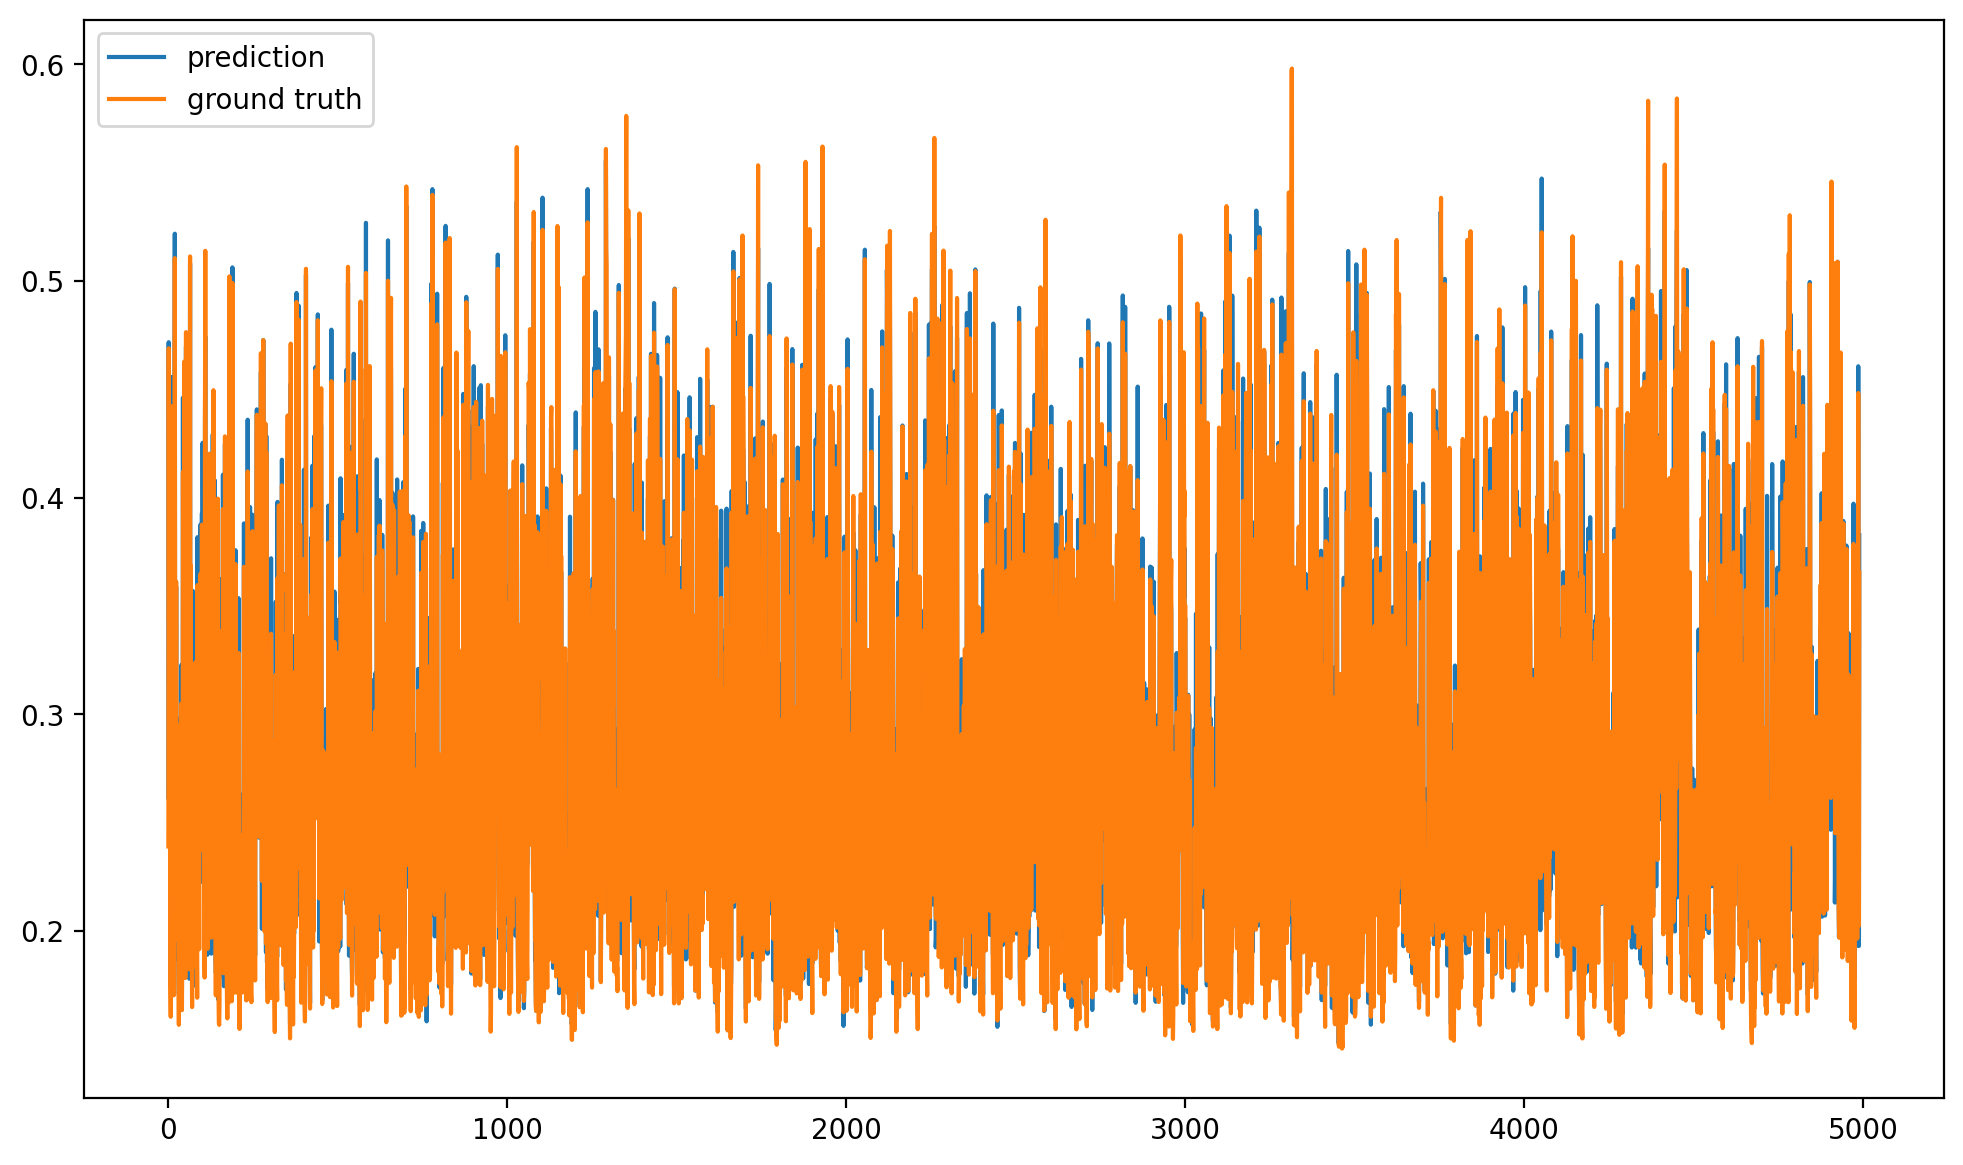

In [37]:
training_loop, history = train_TDNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, best_config['window'], filename='narma-tdnn-prdiction-plot')

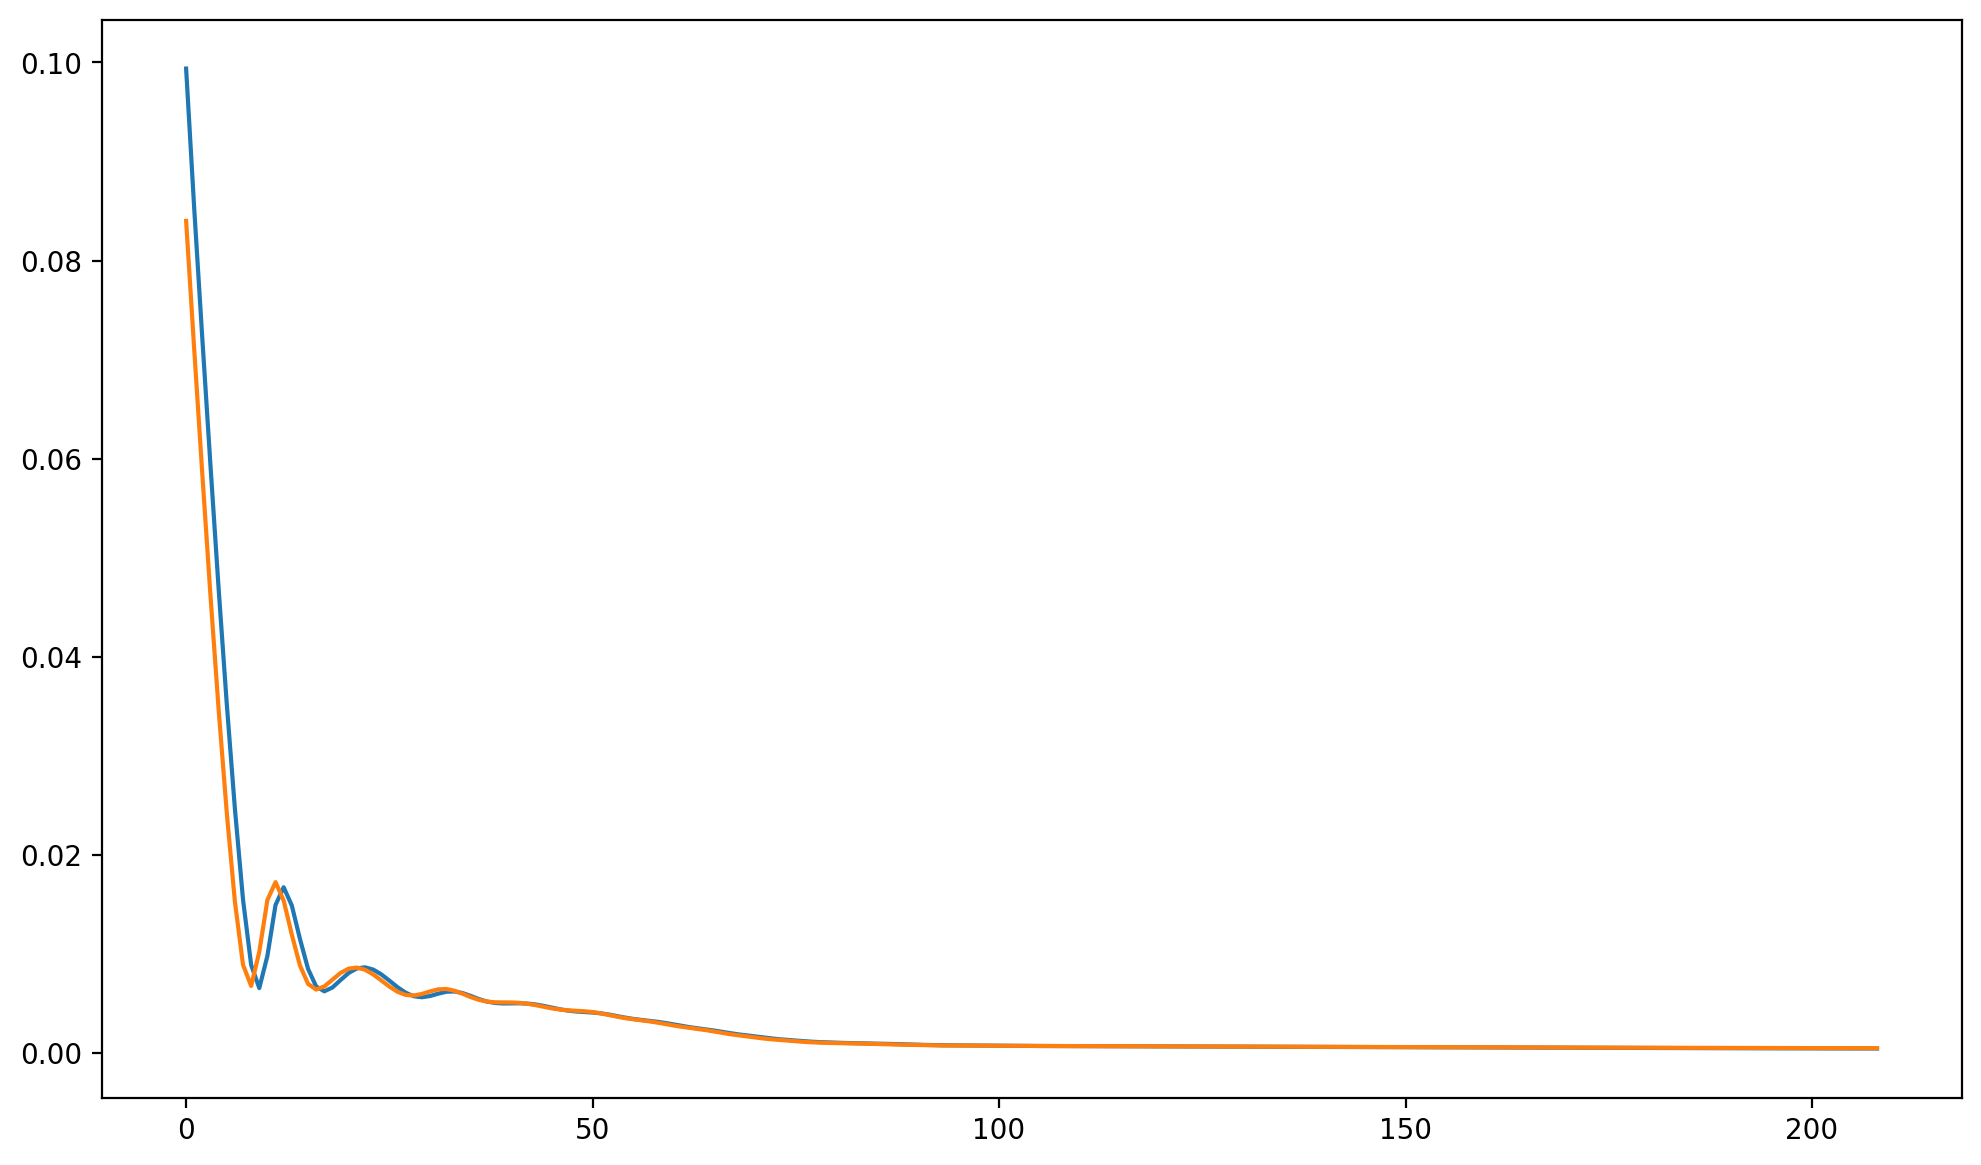

In [38]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.savefig('figures/narma-tdnn-training-curve')
plt.show()

## RNN Model Selection



### Sweep Configuration



In [39]:
rnn_sweep_config = {
    'method': 'bayes',
    'iterations': 10,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'num_layers': {
            'distribution': 'uniform',
            'min': 1,
            'max': 3
        },
        'hidden_size': {
            'distribution': 'uniform',
            'min': 8,
            'max': 256
        }
    },
    'fixed': {
        'lr': 1e-3,
        'input_size': 1,
        'epochs': 100,
        'verbose': 0
    }
}


In [40]:
def train_RNN(dataset, device, config, return_history=False):
    epochs = config['epochs']
    model = StatefulRNN(num_layers=config['num_layers'], hidden_size=config['hidden_size'], input_size=config['input_size'])
    
    loss_fn = torch.nn.MSELoss()
    optimizer = make_optimizer(torch.optim.Adam, lr = config['lr'])
    history = []
    
    training_loop = TrainingLoop(
        dataset,
        loss_fn,
        optimizer,
        train_p = 0.4,
        val_p = 0.1,
        test_p = 0.5,
        random_split = False,
        batch_size = None,
        shuffle = False,
        device = device,
        num_workers = 0,
        seed = 42,
        callbacks = [
            ProgressbarCallback(epochs=epochs, width=20),
            HistoryLoggerCallback(history)
        ]
    )
    training_loop.run(model, epochs = epochs, verbose = config['verbose'])
    if return_history:
        return training_loop, history
    return training_loop

In [41]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :]).view(df.values.shape[1]), torch.from_numpy(df.values[1, :]).view(df.values.shape[1]))
score_function = lambda config: train_RNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(rnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 74}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 202}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 190}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 101}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 206}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 145}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 177}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 174}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 124}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 26}


Best configuration found: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 202}
 with error: 0.0024247500114142895


Test loss: 0.002223727758973837


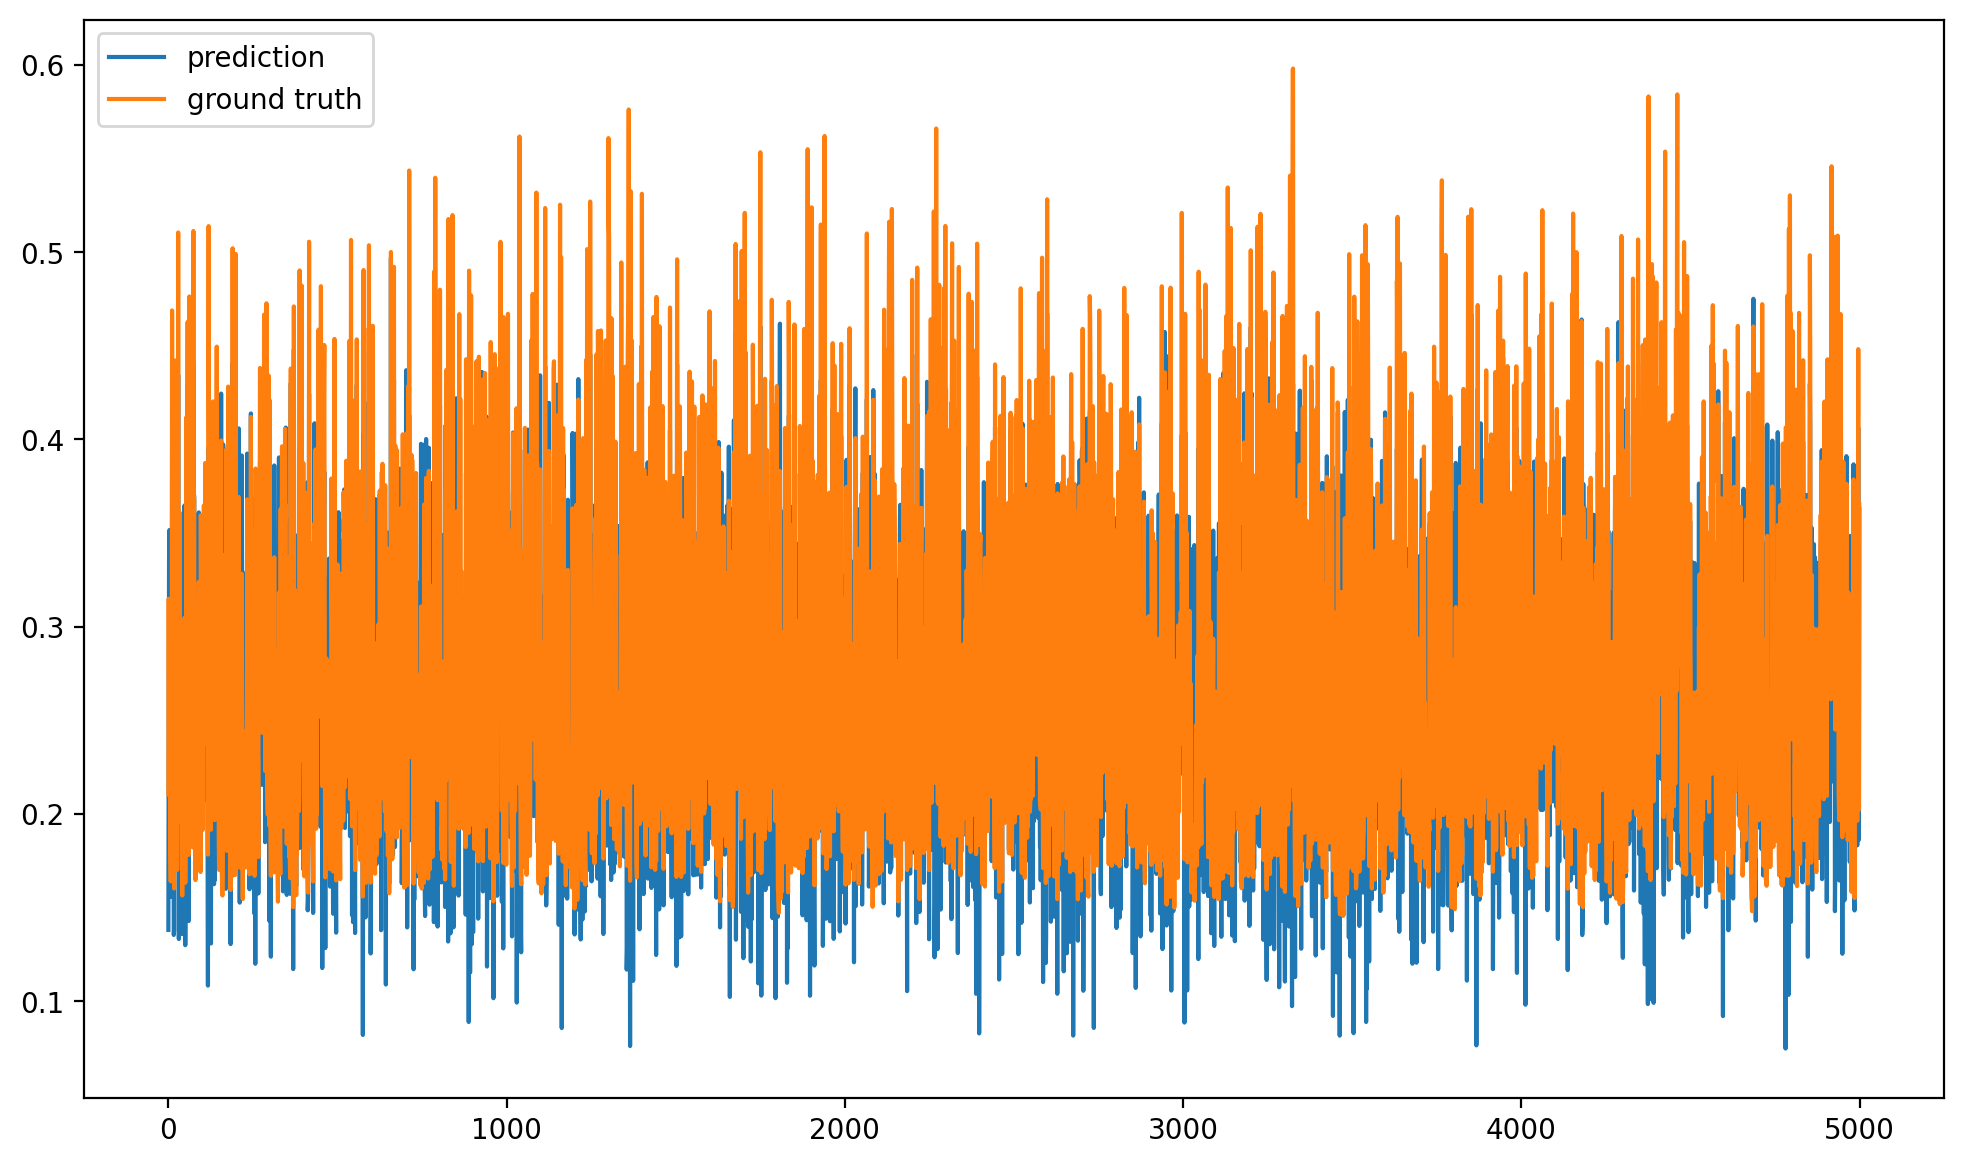

In [42]:
training_loop, history = train_RNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, 0, filename='narma-rnn-prediction-plot')

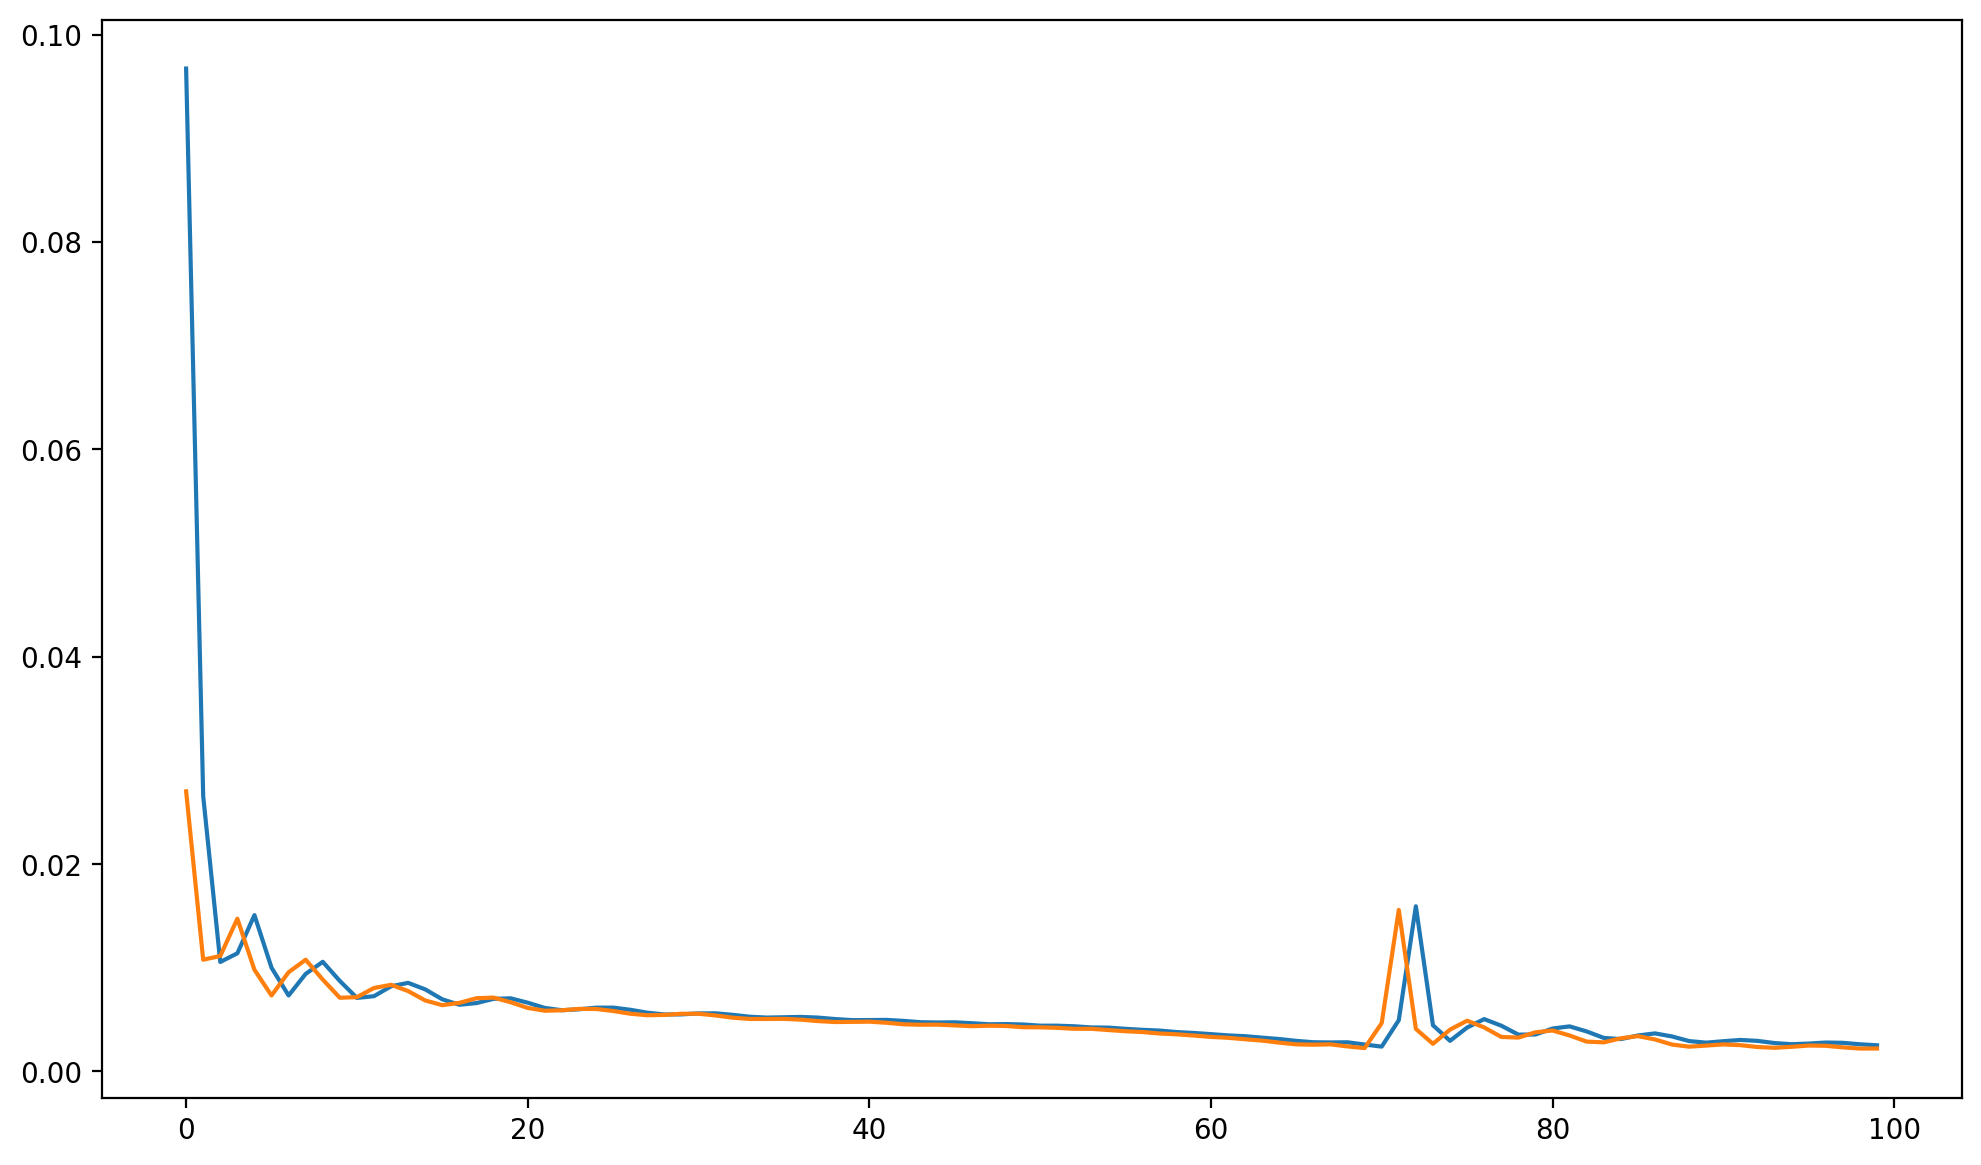

In [43]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.savefig('figures/narma-rnn-training-curve')
plt.show()

# Bonus Track 1



In [44]:
df = pd.read_csv('./MG17.csv', header=None)
print(df.head())

       0         1         2         3        4        5        6        7      
0  0.032164  0.040426  0.057861  0.084015  0.11544  0.14572  0.16758  0.17624  \

      8        9     ...     9990     9991     9992     9993     9994   
0  0.17107  0.15465  ... -0.43905 -0.43957 -0.42772 -0.40213 -0.36305  \

      9995     9996     9997    9998      9999  
0 -0.31286 -0.25555 -0.19556 -0.1368 -0.082192  

[1 rows x 10000 columns]


### TDNN

In [45]:
device = 'cuda'
dataset = TensorDataset(torch.from_numpy(df.values[0, :-1]), torch.from_numpy(df.values[0, 1:]))

score_function = lambda config: train_TDNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(tdnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 525, 'lr': 0.0005584445568562628, 'epochs': 370}


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 609, 'lr': 0.0005992621516606527, 'epochs': 122}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 776, 'lr': 0.00011995258458979528, 'epochs': 178}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 663, 'lr': 0.0005973058485798934, 'epochs': 393}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 159, 'lr': 0.00013992480612727988, 'epochs': 380}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 630, 'lr': 0.0008080973422808508, 'epochs': 353}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 230, 'lr': 0.0006036513674684642, 'epochs': 469}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 991, 'lr': 0.0004944316302874047, 'epochs': 436}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 979, 'lr': 0.0006701847787608615, 'epochs': 121}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 238, 'lr': 0.0003421815502650716, 'epochs': 338}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 543, 'lr': 0.0002371162727155141, 'epochs': 477}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 635, 'lr': 0.0004299811766778911, 'epochs': 306}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 903, 'lr': 0.0005821810528589118, 'epochs': 415}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 182, 'lr': 0.0005768035939951462, 'epochs': 295}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 489, 'lr': 0.0005672745263263466, 'epochs': 427}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 440, 'lr': 0.00037569195890842683, 'epochs': 249}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 959, 'lr': 0.00028913807402099683, 'epochs': 217}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 719, 'lr': 0.00019833544301001624, 'epochs': 106}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 487, 'lr': 0.00010295514514446965, 'epochs': 342}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 2, 'dim': 730, 'lr': 0.00019363917985884424, 'epochs': 235}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 1, 'dim': 784, 'lr': 0.00035700037746281936, 'epochs': 278}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 742, 'lr': 0.00044443490418578425, 'epochs': 371}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 978, 'lr': 0.0006036598769546317, 'epochs': 392}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 3, 'dim': 802, 'lr': 0.0002886649103419877, 'epochs': 255}


Evaluating configuration: {'window': 11, 'verbose': 0, 'num_layers': 5, 'dim': 218, 'lr': 0.00013102694822680127, 'epochs': 116}


Best configuration found: {'window': 11, 'verbose': 0, 'num_layers': 4, 'dim': 978, 'lr': 0.0006036598769546317, 'epochs': 392}
 with error: 9.986815712181851e-06


Test loss: 8.194300789909903e-06


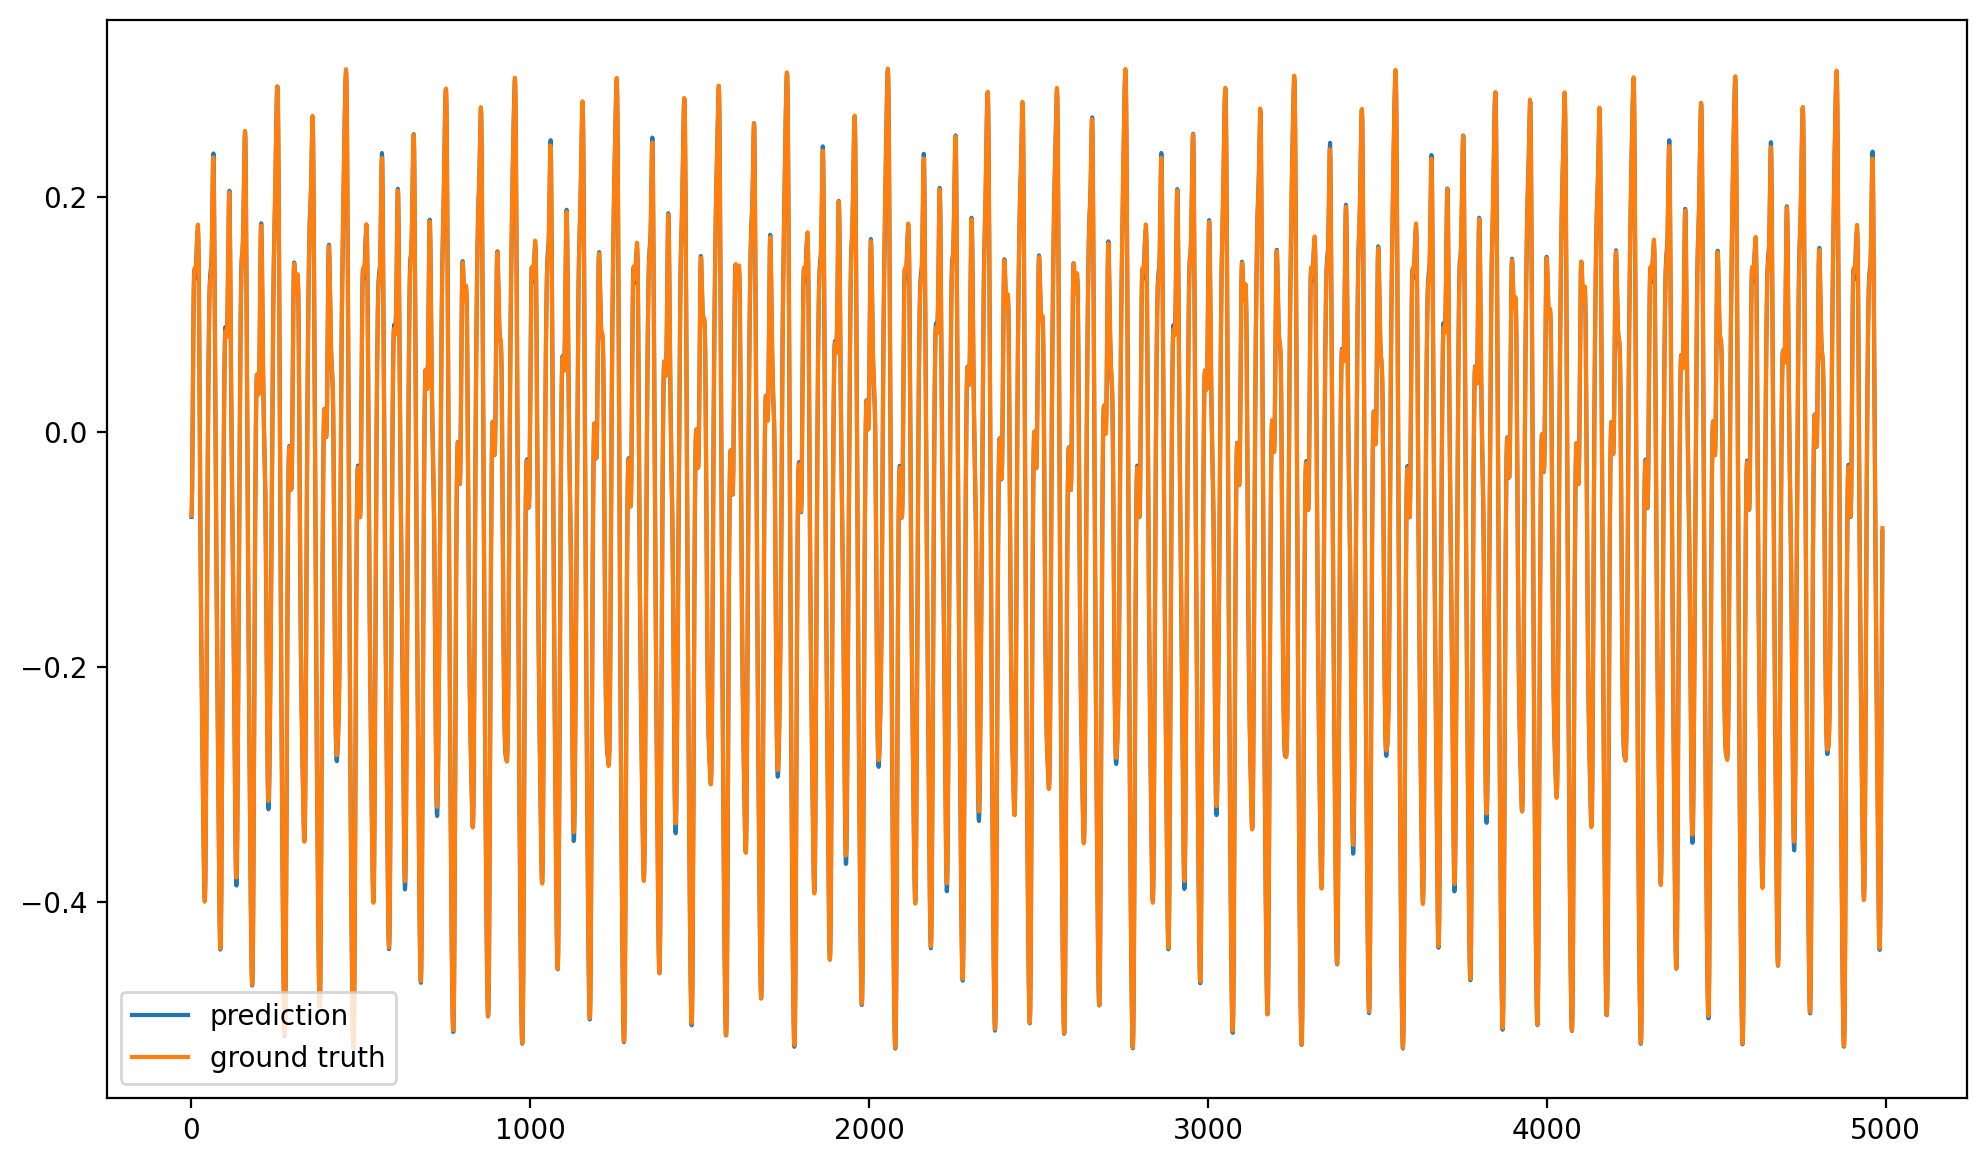

In [46]:
training_loop, history = train_TDNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, best_config['window'], filename='mg17-tdnn-prediction-plot')

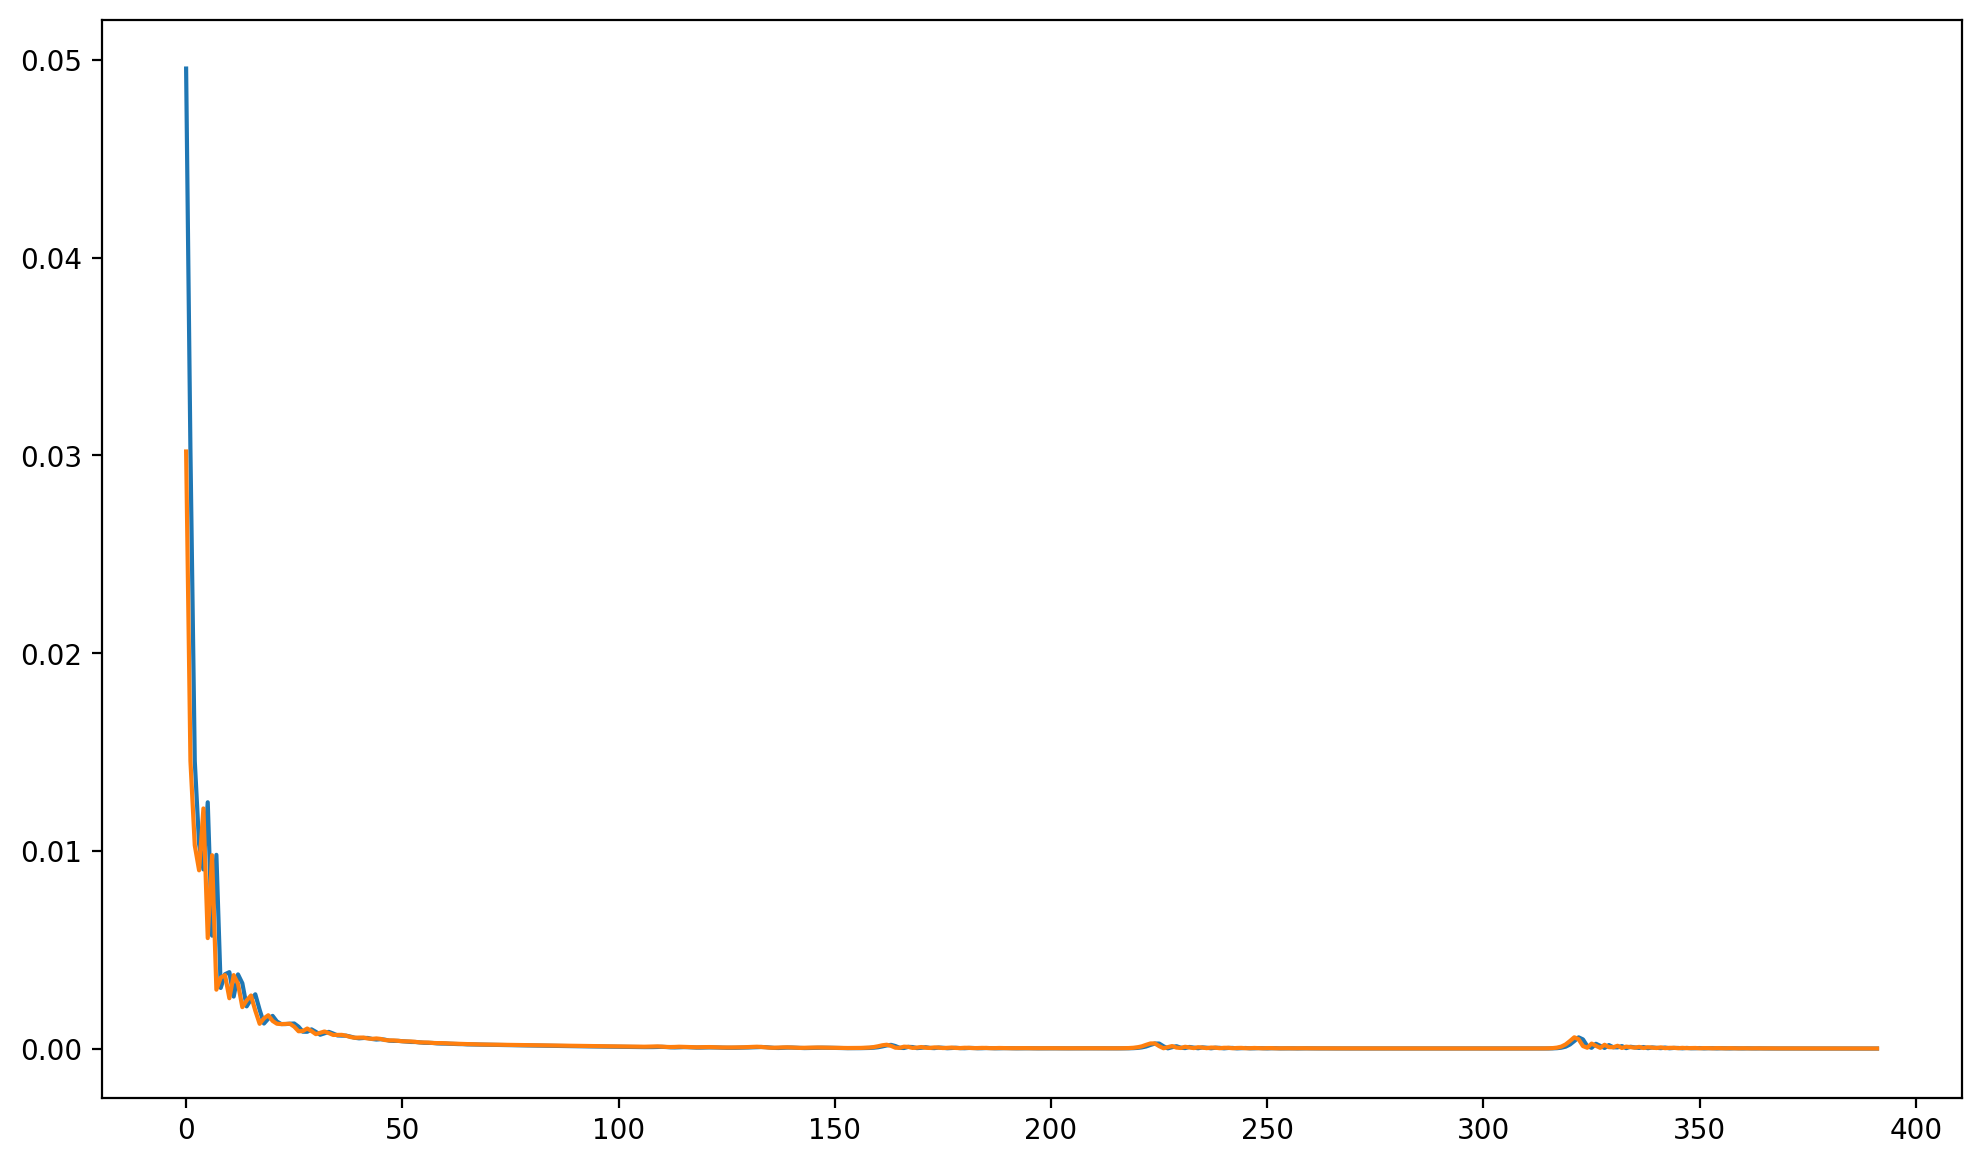

In [47]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.savefig('figures/mg17-tdnn-training-curve')
plt.show()

### RNN



In [48]:
device = 'cuda'
score_function = lambda config: train_RNN(dataset, device, config).get_last_metrics()

optimizer = HyperOptimizer(rnn_sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 89}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 11}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 243}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 110}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 256}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 79}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 1, 'hidden_size': 124}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 234}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 2, 'hidden_size': 62}


Evaluating configuration: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 155}


Best configuration found: {'lr': 0.001, 'input_size': 1, 'epochs': 100, 'verbose': 0, 'num_layers': 3, 'hidden_size': 234}
 with error: 9.596406744094566e-05


Test loss: 0.00014438152720686048


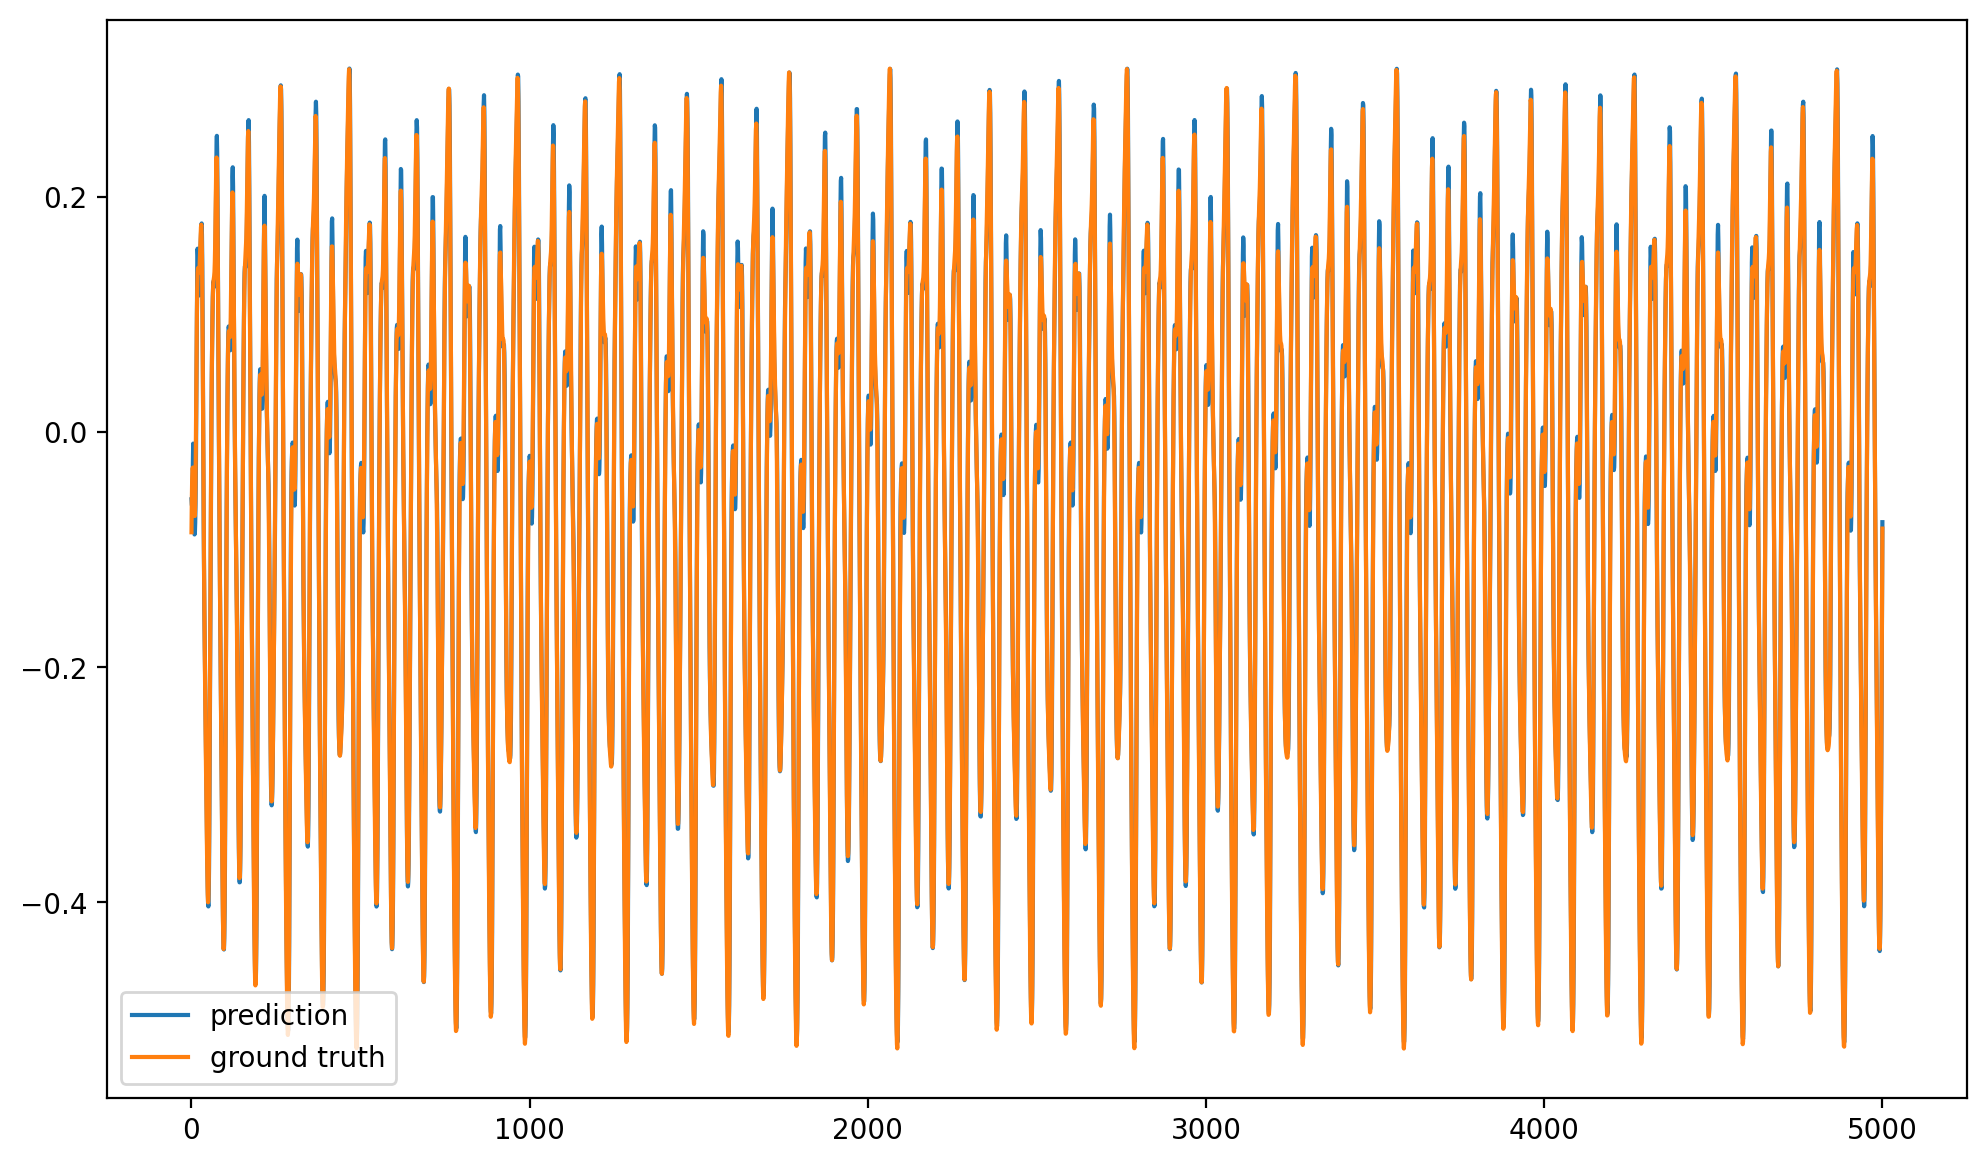

In [49]:
training_loop, history = train_RNN(dataset, device, best_config, return_history=True)
prediction_plot(training_loop, 0, filename='mg17-rnn-prediction-plot')

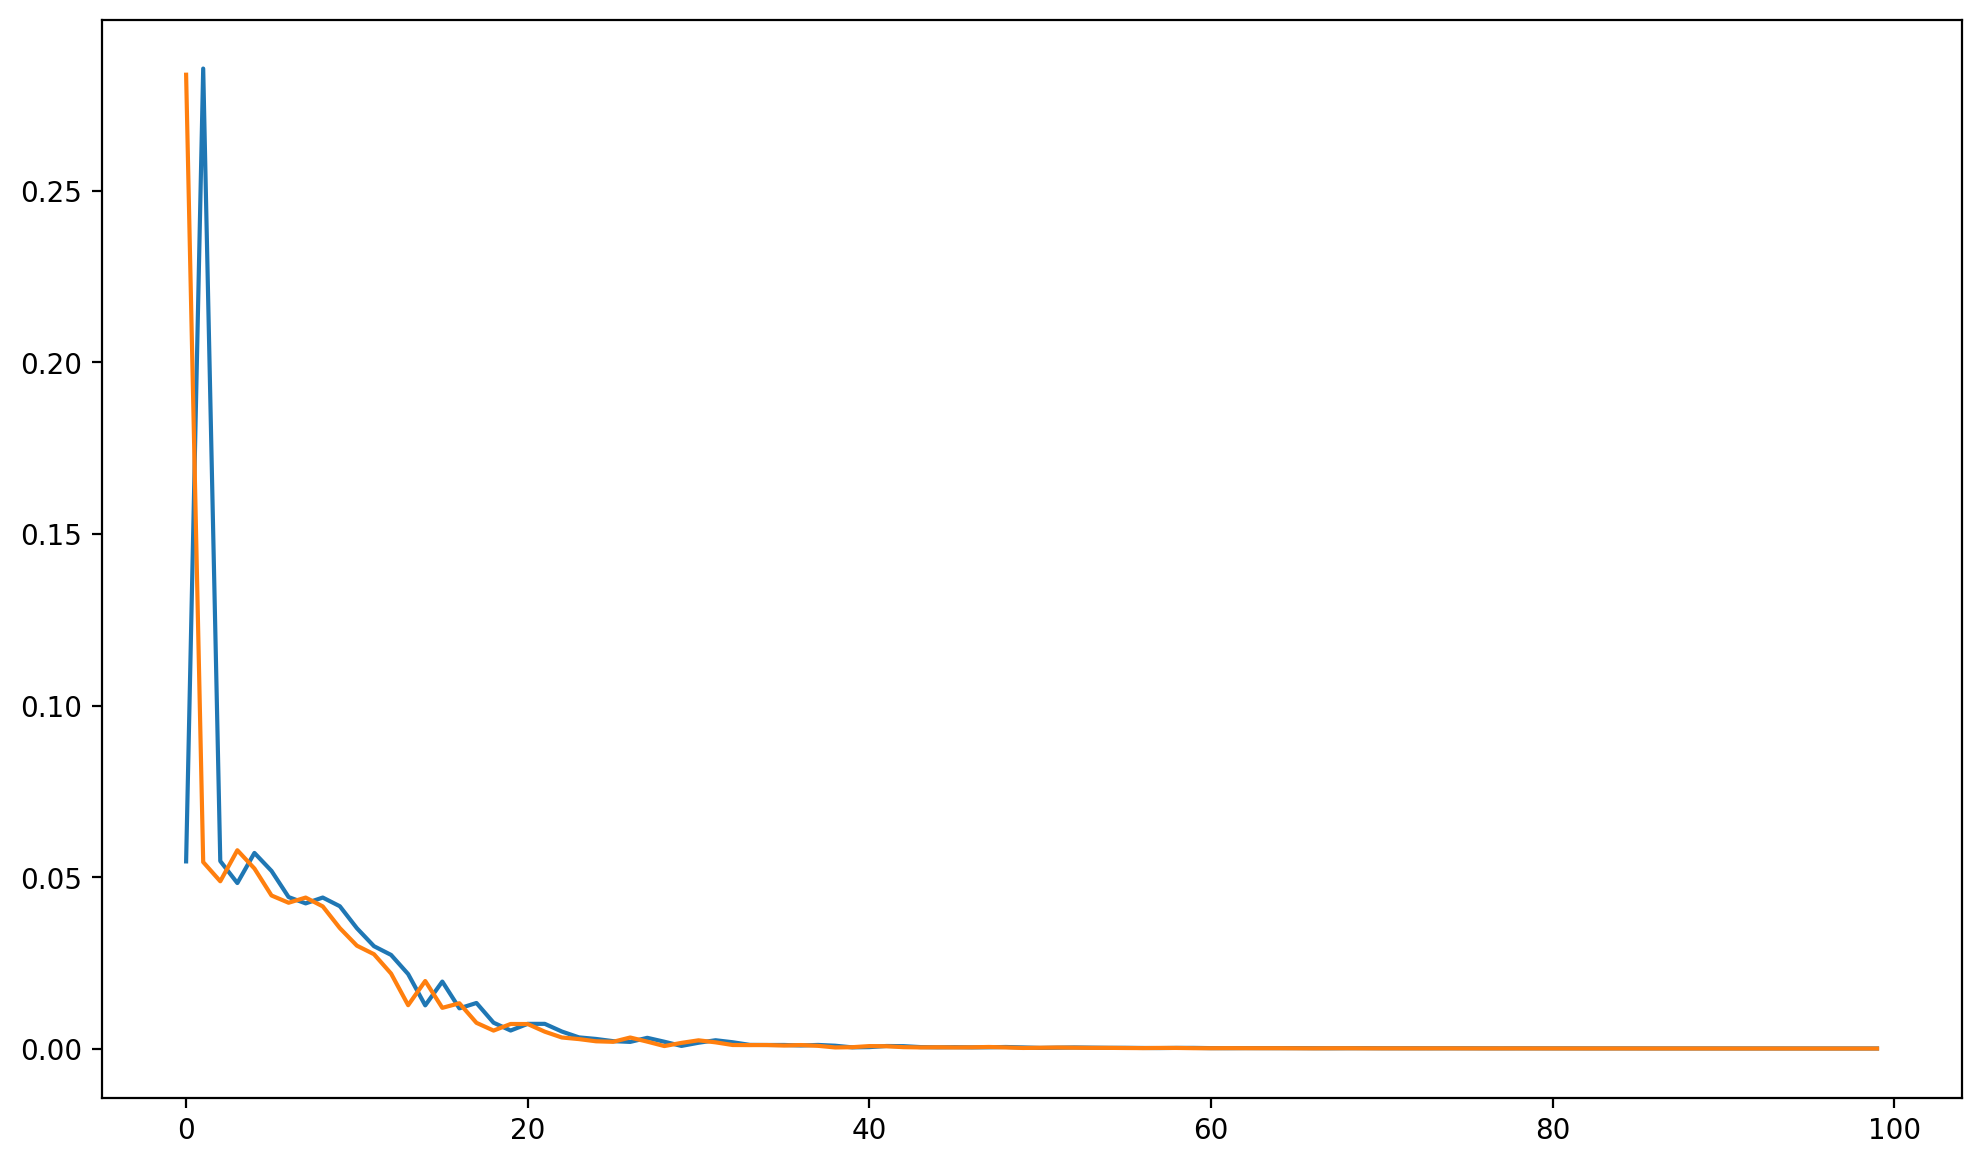

In [50]:
plt.plot(range(len(history)), [l['loss'] for l in history])
plt.plot(range(len(history)), [l['val_loss'] for l in history])
plt.savefig('figures/mg17-rnn-training-curve')
plt.show()